In [1]:
# ============================================
# Imports
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

sns.set(style="whitegrid")
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pande\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pande\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# ============================================
# Load Data
# ============================================
df = pd.read_csv("../data/twitter_airline_cleaned.csv")  
print(df.shape)
df.head()

(14604, 27)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,...,word_count,avg_word_len,has_question,has_exclamation,year,month,day,hour,dayofweek,sentiment_label
0,5.675880e+17,neutral,1.0,NaN,0.0000,Delta,JetBlueNews,0,@JetBlue's new CEO seeks the right balance to please passengers and Wall ... - Greenfield Daily Reporter http://t.co/LM3opxkxch,2015-02-16 23:36:00,...,18,7.055556,0,0,2015,2,16,23,0,0
1,5.675900e+17,negative,1.0,Can't Tell,0.6503,Delta,nesi_1992,0,@JetBlue is REALLY getting on my nerves !! 😡😡 #nothappy,2015-02-16 23:43:00,...,10,5.500000,0,1,2015,2,16,23,0,-1
2,5.675910e+17,negative,1.0,Late Flight,0.3460,United,CPoutloud,0,@united yes. We waited in line for almost an hour to do so. Some passengers just left not wanting to wait past 1am.,2015-02-16 23:48:00,...,23,5.000000,0,0,2015,2,16,23,0,-1
3,5.675920e+17,negative,1.0,Late Flight,1.0000,United,brenduch,0,"@united the we got into the gate at IAH on time and have given our seats and closed the flight. If you know people is arriving, have to wait",2015-02-16 23:52:00,...,29,4.827586,0,0,2015,2,16,23,0,-1
4,5.675940e+17,negative,1.0,Customer Service Issue,0.3451,Southwest,VahidESQ,0,"@SouthwestAir its cool that my bags take a bit longer, dont give me baggage blue balls-turn the carousel on, tell me it's coming, then not.",2015-02-17 00:00:00,...,25,5.560000,0,0,2015,2,17,0,1,-1


In [3]:
# Check total missing values per column
df.isna().sum().sort_values(ascending=False)

negativereason                  5445
processed_text                    17
tweet_id                           0
clean_text                         0
dayofweek                          0
hour                               0
day                                0
month                              0
year                               0
has_exclamation                    0
has_question                       0
avg_word_len                       0
word_count                         0
char_count                         0
has_timezone                       0
airline_sentiment                  0
has_location                       0
user_timezone                      0
tweet_location                     0
tweet_created                      0
text                               0
retweet_count                      0
name                               0
airline                            0
negativereason_confidence          0
airline_sentiment_confidence       0
sentiment_label                    0
d

In [4]:
# ============================
# Handle NaN values 
# ============================
# A. negativereason → fill missing with "None"
df['negativereason'] = df['negativereason'].fillna("None")

# B. processed_text → fill NaN with clean_text
df['processed_text'] = df['processed_text'].fillna(df['clean_text'])

# C. Replace empty strings using boolean mask (safe!)
mask_empty = df['processed_text'].str.strip() == ""
df.loc[mask_empty, 'processed_text'] = df.loc[mask_empty, 'clean_text']

# D. Final safety check: drop rows missing critical fields
critical_cols = ['text', 'clean_text', 'processed_text', 'tweet_created', 'airline_sentiment']
df = df.dropna(subset=critical_cols)

df.isna().sum()

tweet_id                        0
airline_sentiment               0
airline_sentiment_confidence    0
negativereason                  0
negativereason_confidence       0
airline                         0
name                            0
retweet_count                   0
text                            0
tweet_created                   0
tweet_location                  0
user_timezone                   0
has_location                    0
has_timezone                    0
clean_text                      0
processed_text                  0
char_count                      0
word_count                      0
avg_word_len                    0
has_question                    0
has_exclamation                 0
year                            0
month                           0
day                             0
hour                            0
dayofweek                       0
sentiment_label                 0
dtype: int64

In [5]:
# ============================================
# Encode Target
# ============================================
le = LabelEncoder()
df['label'] = le.fit_transform(df['airline_sentiment'])

print(le.classes_)
df[['airline_sentiment', 'label']].head()

['negative' 'neutral' 'positive']


,airline_sentiment,label
0,neutral,1
1,negative,0
2,negative,0
3,negative,0
4,negative,0


In [6]:
# ============================================
# Train/Test Split
# ============================================
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((11683,), (2921,))

In [7]:
# ============================================
# Define Multiple Models (TF-IDF + Classifier)
# ============================================

models = {
    "LogisticRegression": Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            stop_words='english'
        )),
        ('clf', LogisticRegression(max_iter=300))
    ]),
    "LinearSVC": Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            stop_words='english'
        )),
        ('clf', LinearSVC())
    ]),
    "RandomForest": Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            stop_words='english'
        )),
        ('clf', RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            n_jobs=-1,
            random_state=42
        ))
    ]),
    "GradientBoosting": Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            stop_words='english'
        )),
        ('clf', GradientBoostingClassifier(random_state=42))
    ])
}

Training model: LogisticRegression

Accuracy: 0.7751

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.94      0.86      1832
     neutral       0.66      0.44      0.53       618
    positive       0.82      0.59      0.68       471

    accuracy                           0.78      2921
   macro avg       0.76      0.66      0.69      2921
weighted avg       0.77      0.78      0.76      2921



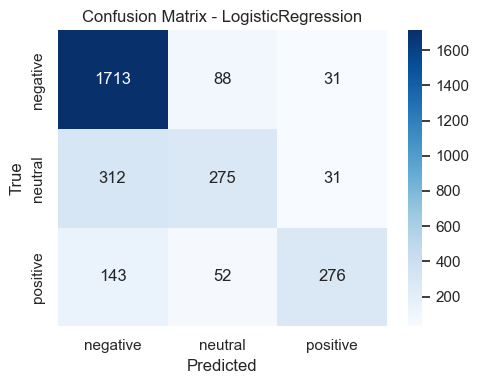

Training model: LinearSVC

Accuracy: 0.7672

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.88      0.85      1832
     neutral       0.59      0.54      0.56       618
    positive       0.74      0.63      0.68       471

    accuracy                           0.77      2921
   macro avg       0.72      0.68      0.70      2921
weighted avg       0.76      0.77      0.76      2921



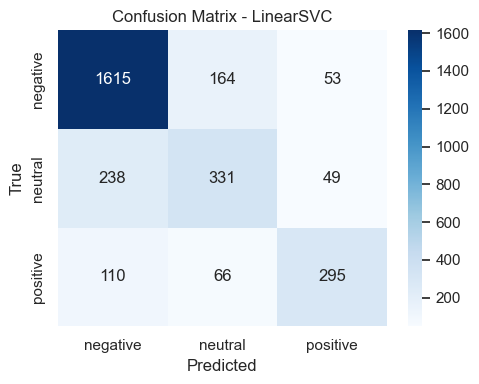

Training model: RandomForest

Accuracy: 0.7525

Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.89      0.84      1832
     neutral       0.60      0.46      0.52       618
    positive       0.70      0.60      0.65       471

    accuracy                           0.75      2921
   macro avg       0.70      0.65      0.67      2921
weighted avg       0.74      0.75      0.74      2921



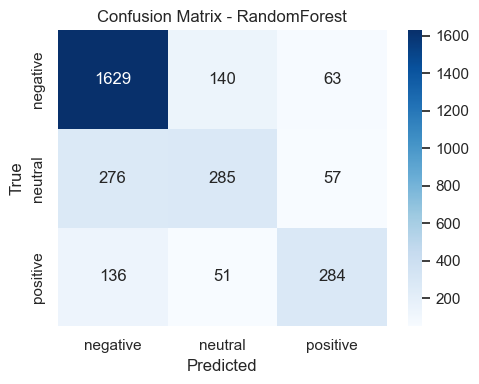

Training model: GradientBoosting

Accuracy: 0.7248

Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.96      0.82      1832
     neutral       0.79      0.15      0.25       618
    positive       0.74      0.56      0.64       471

    accuracy                           0.72      2921
   macro avg       0.75      0.56      0.57      2921
weighted avg       0.74      0.72      0.67      2921



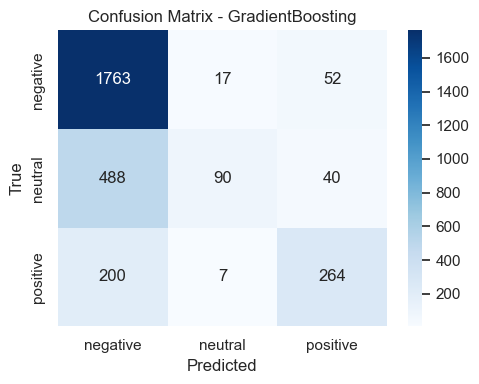


Summary of model accuracies:
LogisticRegression: 0.7751
LinearSVC: 0.7672
RandomForest: 0.7525
GradientBoosting: 0.7248


In [8]:
# ============================================
# Train & Evaluate All Models
# ============================================

results = []

for name, pipe in models.items():
    print("="*60)
    print(f"Training model: {name}")
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))
    
    print(f"\nAccuracy: {acc:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

print("\nSummary of model accuracies:")
for name, acc in results:
    print(f"{name}: {acc:.4f}")

In [9]:
# ============================================
# Pick Best Model & Save
# ============================================

# choose best by accuracy
best_model_name, best_acc = sorted(results, key=lambda x: x[1], reverse=True)[0]
print(f"Best model: {best_model_name} with accuracy {best_acc:.4f}")

best_model = models[best_model_name]

# If want to persist the model:
import joblib
joblib.dump(best_model, f"best_twitter_airline_model_{best_model_name}.joblib")

# Save cleaned data as well
df.to_csv("twitter_airline_cleaned_for_modeling.csv", index=False)

Best model: LogisticRegression with accuracy 0.7751


Logistic Regression achieved the highest accuracy (0.7751), outperforming all other models by leveraging its strength on sparse TF‑IDF features and delivering the most reliable generalization.